In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

BASE = Path('/content/drive/MyDrive/IA-1/DetectorPhishing')
FEAT = BASE/'data/processed/features_full.csv'

df = pd.read_csv(FEAT)
print("shape:", df.shape)
df.head(3)


shape: (641125, 26)


,len_total,len_host,len_path,len_query,dots,hyphens,underscores,digits,percents,ats,...,has_ip,port_explicit,digit_ratio,symbol_ratio,tld_len,tld_rare,entropy_host,entropy_path,sus_words,label
0,16,16,0,0,2,1,0,0,0,0,...,0,0,0.000000,0.187500,2,0,3.375000,0.000000,0,1
1,35,11,24,0,2,0,1,1,0,0,...,0,0,0.028571,0.085714,3,0,3.277613,3.855389,0,0
2,31,14,17,0,2,0,0,1,0,0,...,0,0,0.032258,0.064516,3,0,3.235926,3.292770,0,0


In [ ]:
y = df['label'].astype(int).values
X = df.drop(columns=['label'])

n = min(20000, len(X))
X_s = X.sample(n, random_state=42)
y_s = y[X_s.index]

scaler = StandardScaler()
Xs = scaler.fit_transform(X_s)

Xs.shape, np.bincount(y_s)


((20000, 25), array([13285,  6715]))

PCA varianza explicada (PC1, PC2): [0.188 0.145]


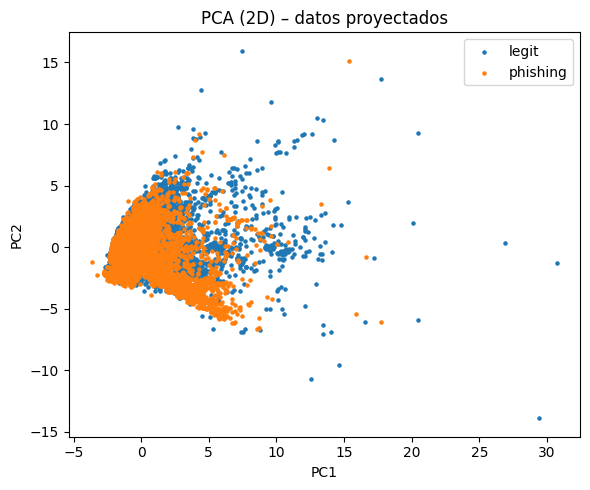

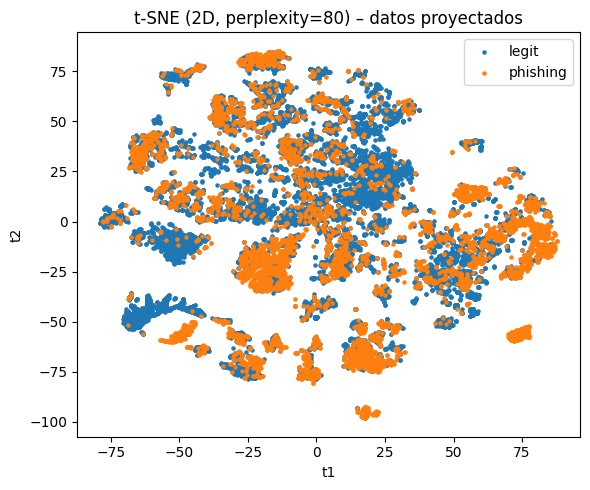

In [ ]:
# --- PCA 2D ---
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(Xs)
print('PCA varianza explicada (PC1, PC2):', pca.explained_variance_ratio_.round(3))

plt.figure(figsize=(6,5))
plt.scatter(Z_pca[y_s==0,0], Z_pca[y_s==0,1], s=5, label='legit')
plt.scatter(Z_pca[y_s==1,0], Z_pca[y_s==1,1], s=5, label='phishing')
plt.title('PCA (2D) – datos proyectados'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend()
plt.tight_layout(); plt.show()

# --- t-SNE 2D ---
tsne = TSNE(n_components=2, perplexity=80, learning_rate='auto', init='pca', random_state=42)
Z_tsne = tsne.fit_transform(Xs)

plt.figure(figsize=(6,5))
plt.scatter(Z_tsne[y_s==0,0], Z_tsne[y_s==0,1], s=5, label='legit')
plt.scatter(Z_tsne[y_s==1,0], Z_tsne[y_s==1,1], s=5, label='phishing')
plt.title('t-SNE (2D, perplexity=80) – datos proyectados'); plt.xlabel('t1'); plt.ylabel('t2'); plt.legend()
plt.tight_layout(); plt.show()



KMeans sobre PCA (k=2) – tabla cluster vs etiqueta:
label        0     1
cluster             
0        12141  4734
1         1144  1981


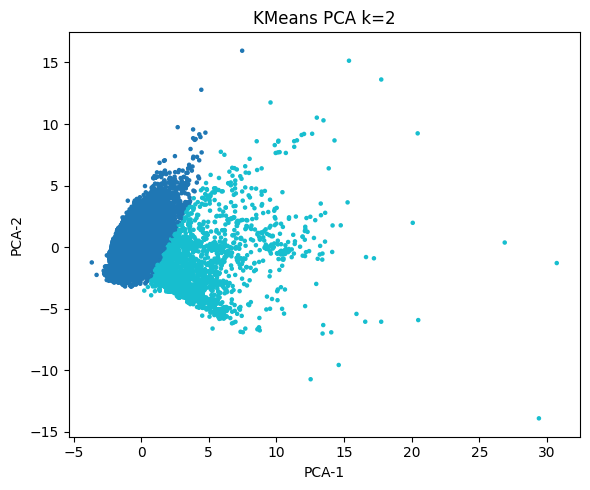


KMeans sobre t-SNE (k=2) – tabla cluster vs etiqueta:
label       0     1
cluster            
0        7794  1935
1        5491  4780


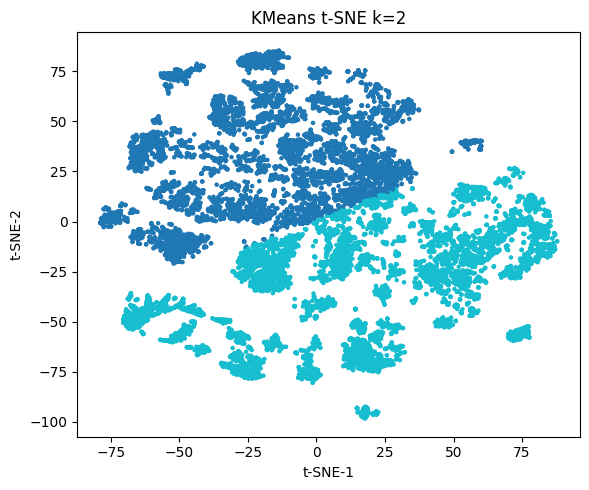

In [ ]:
def kmeans_2d_and_plot(Z, y_s, name, k=2):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    c = km.fit_predict(Z)


    tab = pd.crosstab(c, y_s, rownames=['cluster'], colnames=['label'])
    print(f"\nKMeans sobre {name} (k={k}) – tabla cluster vs etiqueta:")
    print(tab)


    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=c, s=5, cmap='tab10')
    plt.title(f'KMeans {name} k={k}'); plt.xlabel(f'{name}-1'); plt.ylabel(f'{name}-2')
    plt.tight_layout(); plt.show()


kmeans_2d_and_plot(Z_pca,  y_s, 'PCA',  k=2)
kmeans_2d_and_plot(Z_tsne, y_s, 't-SNE', k=2)


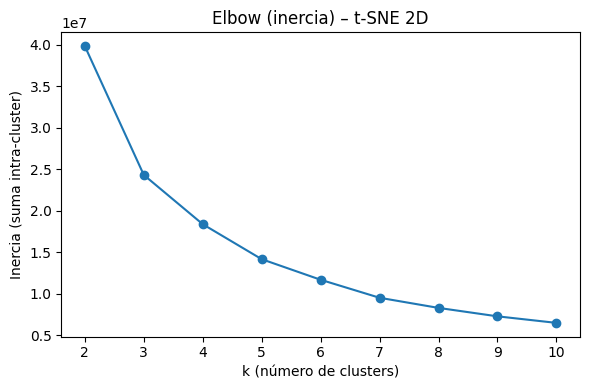

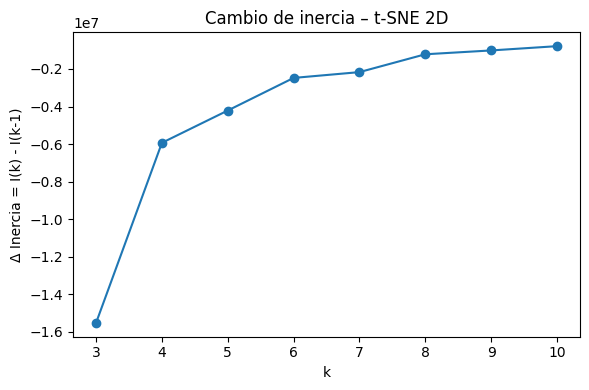

In [ ]:
# --- Elbow (inercia vs k) sobre Z_tsne ---
from sklearn.cluster import KMeans

def elbow_plot_tsne(Z_tsne, k_min=2, k_max=10):
    ks = list(range(k_min, k_max+1))
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        km.fit(Z_tsne)
        inertias.append(km.inertia_)

    # Curva de inercia
    plt.figure(figsize=(6,4))
    plt.plot(ks, inertias, marker='o')
    plt.xticks(ks)
    plt.title('Elbow (inercia) – t-SNE 2D')
    plt.xlabel('k (número de clusters)')
    plt.ylabel('Inercia (suma intra-cluster)')
    plt.tight_layout(); plt.show()

    # Cambios entre ks consecutivos (ayuda a ver el “codo”)
    diffs = np.diff(inertias)
    plt.figure(figsize=(6,4))
    plt.plot(ks[1:], diffs, marker='o')
    plt.xticks(ks[1:])
    plt.title('Cambio de inercia – t-SNE 2D')
    plt.xlabel('k'); plt.ylabel('Δ Inercia = I(k) - I(k-1)')
    plt.tight_layout(); plt.show()

    return ks, inertias, diffs

ks_tsne, inert_tsne, dif_tsne = elbow_plot_tsne(Z_tsne, k_min=2, k_max=10)


label,0,1,phish_ratio
cluster,,,
0,3428,959,0.219
1,2230,2190,0.495
2,4689,1043,0.182
3,2938,2523,0.462


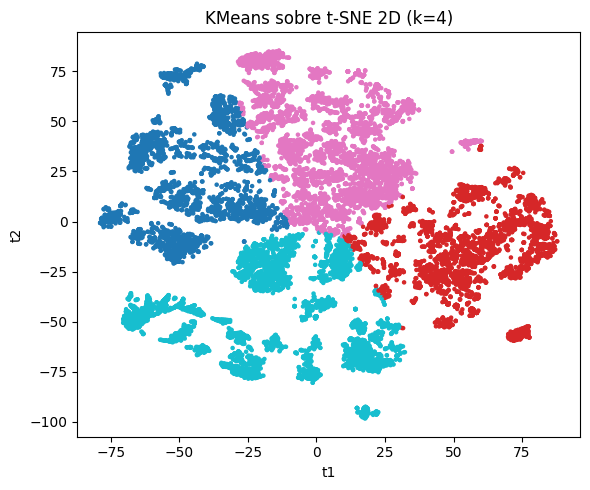

In [ ]:
# --- KMeans con el k elegido, tabla y gráfico ---
import pandas as pd
from sklearn.cluster import KMeans

BEST_K = 4  # <--- AJUSTA AQUÍ según el codo

km = KMeans(n_clusters=BEST_K, n_init=10, random_state=42)
c_tsne = km.fit_predict(Z_tsne)

# Tabla cluster vs etiqueta (0=legit, 1=phishing) + proporción de phishing
tab = pd.crosstab(c_tsne, y_s, rownames=['cluster'], colnames=['label'])
tab['phish_ratio'] = (tab[1] / tab.sum(axis=1)).round(3)
display(tab)

# Gráfico coloreado por cluster
plt.figure(figsize=(6,5))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=c_tsne, s=5, cmap='tab10')
plt.title(f'KMeans sobre t-SNE 2D (k={BEST_K})')
plt.xlabel('t1'); plt.ylabel('t2')
plt.tight_layout(); plt.show()


In [ ]:
import numpy as np, pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


#DBSCAN sobre t-SNE 2D
nn = NearestNeighbors(n_neighbors=5).fit(Z_tsne)
dist, _ = nn.kneighbors(Z_tsne)
kdist = np.sort(dist[:, -1])
eps = float(np.percentile(kdist, 95))
db = DBSCAN(eps=eps, min_samples=5, n_jobs=-1).fit(Z_tsne)
labels = pd.Series(db.labels_, index=X_s.index, name='cluster')

#armar DataFrame maestro alineando índices
df_emb = pd.DataFrame(Z_tsne, columns=['t1','t2'], index=X_s.index)
y_ser = pd.Series(y_s, index=X_s.index, name='label')

df_all = pd.concat([df_emb, labels, y_ser, X_s], axis=1)
df_all.head()


,t1,t2,cluster,label,len_total,len_host,len_path,len_query,dots,hyphens,...,subdomains,has_ip,port_explicit,digit_ratio,symbol_ratio,tld_len,tld_rare,entropy_host,entropy_path,sus_words
268915,-2.693427,12.478148,0,0,56,14,42,0,2,0,...,0,0,0,0.000000,0.035714,3,0,3.039149,4.014358,0
163676,20.056147,14.352867,1,0,85,11,74,0,1,10,...,0,0,0,0.082353,0.129412,3,0,3.095795,4.289355,0
425909,-0.716993,19.418137,2,0,50,15,35,0,1,0,...,0,0,0,0.120000,0.020000,3,0,3.506891,4.207436,0
399598,57.099186,39.495872,3,0,158,7,151,0,1,2,...,0,0,0,0.341772,0.284810,3,0,2.807355,3.708288,0
111760,55.599922,-37.206089,4,0,31,11,6,13,1,1,...,0,0,0,0.064516,0.129032,3,0,3.095795,2.584963,0


In [ ]:
# Conteos por cluster
print("Conteo por cluster:")
print(df_all['cluster'].value_counts().sort_index())

# Tabla cluster x etiqueta + proporción de phishing
tab = pd.crosstab(df_all['cluster'], df_all['label'])
tab['phish_ratio'] = (tab.get(1, 0) / tab.sum(axis=1)).round(3)
tab.sort_values('phish_ratio', ascending=False)


Conteo por cluster:
cluster
-1       526
 0       139
 1      1379
 2        27
 3       126
        ... 
 265       6
 266       7
 267       6
 268       7
 269       4
Name: count, Length: 271, dtype: int64


label,0,1,phish_ratio
cluster,,,
265,0,6,1.0
69,0,33,1.0
46,0,129,1.0
27,0,6,1.0
240,0,7,1.0
...,...,...,...
241,8,0,0.0
239,6,0,0.0
264,6,0,0.0


In [ ]:
import numpy as np

def resumen_cluster(cluster_id, top=10, mostrar_muestras=5):
    sub = df_all[df_all['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} | filas={len(sub)}")
    if len(sub)==0:
        return sub

    # muestras
    cols_show = ['t1','t2','label'] + [c for c in X_s.columns[:8]]  # muestra primeras 8 features
    display(sub[cols_show].head(mostrar_muestras))

    # phishing ratio del cluster
    pr = (sub['label'].sum() / len(sub)) if len(sub)>0 else np.nan
    print(f"phish_ratio: {pr:.3f}")

    # features “destacadas”: diferencia de medias vs global
    feats = X_s.columns
    mean_global = X_s[feats].mean()
    mean_cluster = sub[feats].mean()
    diff = (mean_cluster - mean_global).abs().sort_values(ascending=False)
    top_feats = diff.head(top).index.tolist()
    print("\nTop features por diferencia absoluta de media (cluster vs global):")
    display(pd.DataFrame({
        'mean_cluster': mean_cluster[top_feats].round(3),
        'mean_global': mean_global[top_feats].round(3),
        'abs_diff'   : diff[top_feats].round(3)
    }))

    return sub


In [ ]:
# columnas de features (todas menos t1,t2, cluster, label)
feat_cols = [c for c in df_all.columns if c not in ['t1','t2','cluster','label']]

# conteos y % phishing por cluster
cluster_basic = (df_all
                 .groupby('cluster')
                 .agg(total=('label','size'),
                      phishing=('label','sum'))
                )
cluster_basic['phish_ratio'] = (cluster_basic['phishing'] / cluster_basic['total']).round(3)

keys = ['len_total','len_host','len_path','len_query','dots','hyphens','digit_ratio',
        'symbol_ratio','tld_len','entropy_host','entropy_path','sus_words']
cluster_means = df_all.groupby('cluster')[keys].mean().round(3)

print("== Conteo y % phishing por cluster ==")
display(cluster_basic.sort_index())
print("== Medias de features clave por cluster ==")
display(cluster_means)


== Conteo y % phishing por cluster ==


,total,phishing,phish_ratio
cluster,,,
-1,526,148,0.281
0,139,21,0.151
1,1379,121,0.088
2,27,1,0.037
3,126,17,0.135
...,...,...,...
265,6,6,1.000
266,7,1,0.143
267,6,4,0.667


== Medias de features clave por cluster ==


,len_total,len_host,len_path,len_query,dots,hyphens,digit_ratio,symbol_ratio,tld_len,entropy_host,entropy_path,sus_words
cluster,,,,,,,,,,,,
-1,70.253,15.511,31.238,23.127,2.281,1.804,0.123,0.100,2.762,3.247,3.450,0.192
0,48.640,14.007,34.633,0.000,1.338,0.712,0.081,0.045,3.000,3.309,3.908,0.000
1,86.176,14.105,71.947,0.117,1.392,8.365,0.080,0.112,2.959,3.267,4.235,0.005
2,46.296,14.926,31.370,0.000,1.000,0.481,0.125,0.033,3.000,3.425,3.944,0.000
3,152.548,9.841,141.421,1.238,1.127,2.325,0.309,0.284,2.810,2.921,3.434,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
265,130.333,11.500,10.000,107.833,4.000,0.333,0.059,0.155,2.000,3.300,3.122,0.000
266,126.429,19.571,106.857,0.000,2.143,1.143,0.372,0.042,2.857,3.588,4.621,1.286
267,33.667,12.500,21.167,0.000,2.167,0.833,0.119,0.090,3.000,3.233,3.896,0.000


In [ ]:
# promedio global de cada feature
glob_mean = df_all[feat_cols].mean()

def top_features_cluster(cid, top=10):
    sub_mean = df_all[df_all['cluster']==cid][feat_cols].mean()
    diff = (sub_mean - glob_mean).abs().sort_values(ascending=False)
    topf = diff.head(top).index
    out = pd.DataFrame({
        'mean_cluster': sub_mean[topf].round(3),
        'mean_global' : glob_mean[topf].round(3),
        'abs_diff'    : diff[topf].round(3)
    })
    print(f"\n== Cluster {cid} | filas={len(df_all[df_all['cluster']==cid])} ==")
    display(out)

# ejemplo: ver top-10 del cluster -1 (ruido) y del 0
top_features_cluster(-1, top=10)
top_features_cluster(0,  top=10)
top_features_cluster(265,  top=10)


== Cluster -1 | filas=526 ==


,mean_cluster,mean_global,abs_diff
len_total,70.253,56.938,13.315
len_query,23.127,11.532,11.595
digits,8.918,5.342,3.576
len_path,31.238,28.571,2.667
len_host,15.511,16.624,1.113
equals,1.051,0.597,0.454
slashes,2.658,2.384,0.274
hyphens,1.804,1.538,0.266
dots,2.281,2.016,0.265
entropy_path,3.450,3.218,0.232



== Cluster 0 | filas=139 ==


,mean_cluster,mean_global,abs_diff
len_query,0.000,11.532,11.532
len_total,48.640,56.938,8.297
len_path,34.633,28.571,6.062
path_depth,5.014,2.326,2.688
slashes,5.014,2.384,2.631
len_host,14.007,16.624,2.617
digits,3.626,5.342,1.716
hyphens,0.712,1.538,0.826
entropy_path,3.908,3.218,0.690
dots,1.338,2.016,0.678



== Cluster 265 | filas=6 ==


,mean_cluster,mean_global,abs_diff
len_query,107.833,11.532,96.301
len_total,130.333,56.938,73.396
len_path,10.000,28.571,18.571
equals,6.000,0.597,5.403
len_host,11.500,16.624,5.124
amps,5.000,0.378,4.622
underscores,3.833,0.422,3.411
digits,7.833,5.342,2.491
dots,4.000,2.016,1.984
slashes,1.000,2.384,1.384


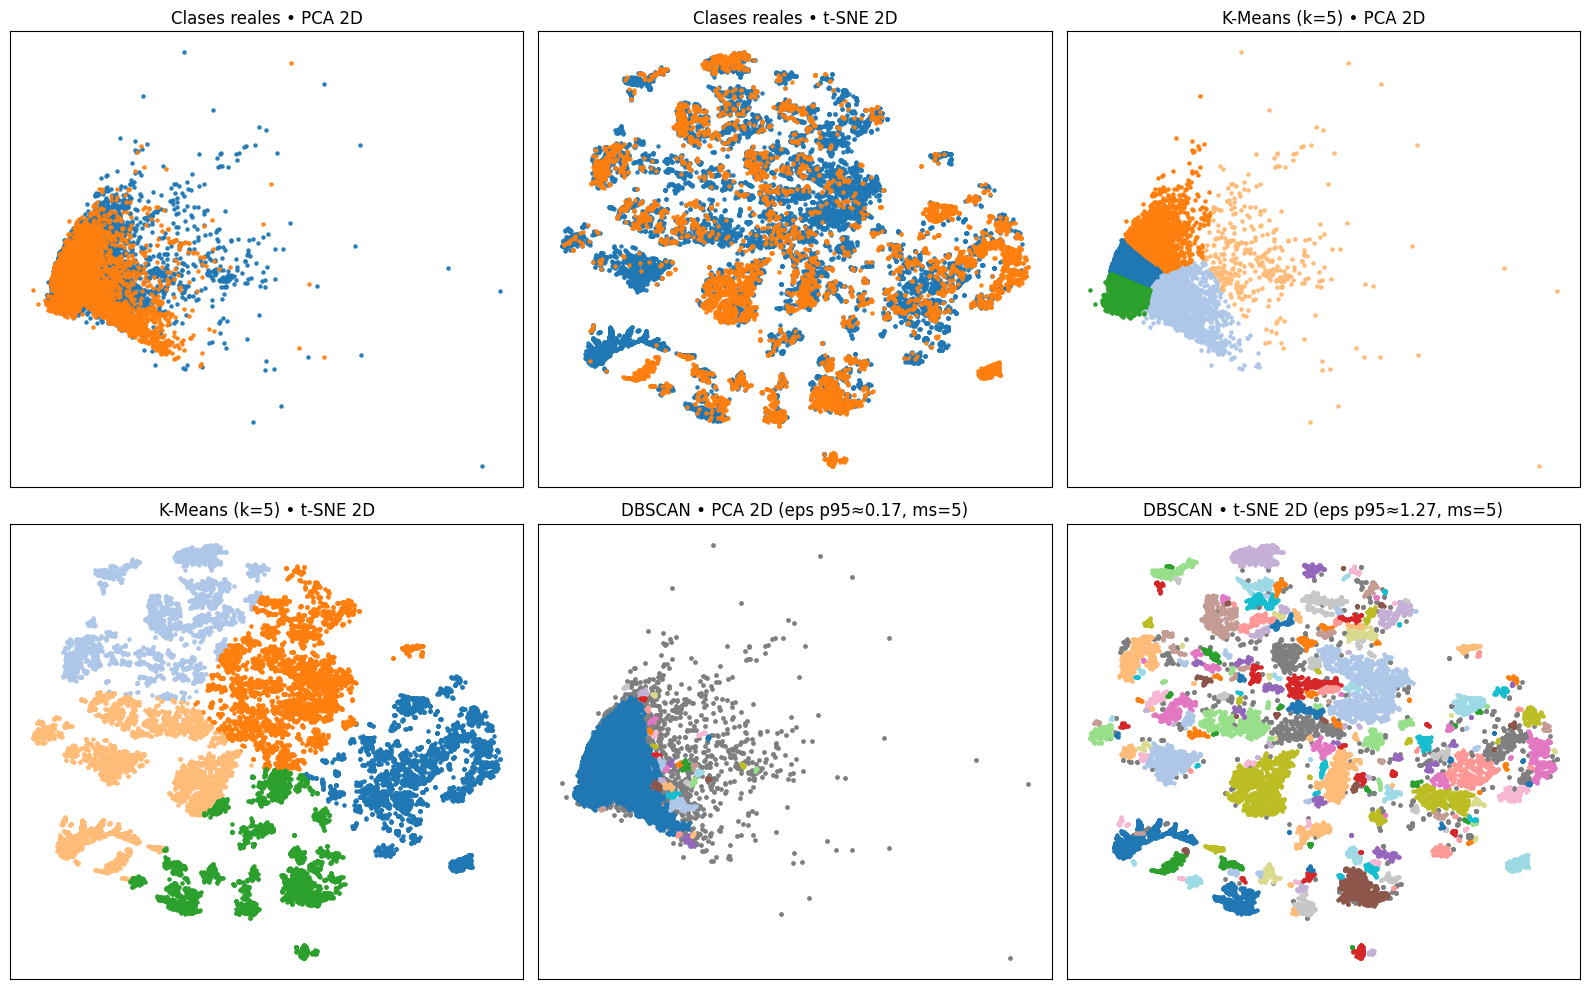

Guardado: /content/drive/MyDrive/IA-1/DetectorPhishing/reports/clustering_grid_2x3_sin_leyendas.png


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from pathlib import Path

# ==== hiperparámetros ====
K_BEST = 5        # ajusta según tu "codo"
PCTL_EPS = 95     # percentil para eps en DBSCAN
MIN_SAMPLES = 5

# ==== helpers (SIN LEYENDAS / SIN EJES) ====
def kmeans_labels(Z, k=K_BEST):
    return KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(Z)

def dbscan_labels(Z, pctl=PCTL_EPS, min_samples=MIN_SAMPLES):
    nn = NearestNeighbors(n_neighbors=5).fit(Z)
    dist, _ = nn.kneighbors(Z)
    kdist = np.sort(dist[:, -1])
    eps = float(np.percentile(kdist, pctl))
    lab = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit_predict(Z)
    return lab, eps

def scatter_labels(ax, Z, y, title):
    ax.scatter(Z[y==0,0], Z[y==0,1], s=5, alpha=0.9)
    ax.scatter(Z[y==1,0], Z[y==1,1], s=5, alpha=0.9)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel(''); ax.set_ylabel('')

def scatter_clusters(ax, Z, labels, title):
    uniq = np.unique(labels)
    cmap = plt.get_cmap('tab20')
    # pinta ruido (-1) en gris si existe
    if -1 in uniq:
        m = (labels==-1)
        ax.scatter(Z[~m,0], Z[~m,1], s=3, c='#d0d0d0', alpha=0.35)
        ax.scatter(Z[m,0],  Z[m,1],  s=6, c='#7f7f7f')
        uniq = uniq[uniq!=-1]
    for u in uniq:
        m = (labels==u)
        ax.scatter(Z[m,0], Z[m,1], s=5, color=cmap(u % 20))
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel(''); ax.set_ylabel('')

# ==== calcula etiquetas de clustering ====
c_km_pca  = kmeans_labels(Z_pca,  k=K_BEST)
c_km_tsne = kmeans_labels(Z_tsne, k=K_BEST)

c_db_pca,  eps_pca  = dbscan_labels(Z_pca,  pctl=PCTL_EPS, min_samples=MIN_SAMPLES)
c_db_tsne, eps_tsne = dbscan_labels(Z_tsne, pctl=PCTL_EPS, min_samples=MIN_SAMPLES)

# ==== figura 2x3 (solo títulos) ====
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Fila 1
scatter_labels(axs[0,0], Z_pca,  y_s, 'Clases reales • PCA 2D')
scatter_labels(axs[0,1], Z_tsne, y_s, 'Clases reales • t-SNE 2D')
scatter_clusters(axs[0,2], Z_pca,  c_km_pca,  f'K-Means (k={K_BEST}) • PCA 2D')

# Fila 2
scatter_clusters(axs[1,0], Z_tsne, c_km_tsne, f'K-Means (k={K_BEST}) • t-SNE 2D')
scatter_clusters(axs[1,1], Z_pca,  c_db_pca,  f'DBSCAN • PCA 2D (eps p{PCTL_EPS}≈{eps_pca:.2f}, ms={MIN_SAMPLES})')
scatter_clusters(axs[1,2], Z_tsne, c_db_tsne, f'DBSCAN • t-SNE 2D (eps p{PCTL_EPS}≈{eps_tsne:.2f}, ms={MIN_SAMPLES})')

plt.tight_layout()
plt.show()

# (opcional) guardar en Drive
try:
    BASE = Path('/content/drive/MyDrive/IA-1/DetectorPhishing')
    out = BASE/'reports'
    out.mkdir(parents=True, exist_ok=True)
    fig.savefig(out/'clustering_grid_2x3_sin_leyendas.png', dpi=160)
    print('Guardado:', out/'clustering_grid_2x3_sin_leyendas.png')
except Exception as e:
    print('No se guardó en Drive:', e)
